## **프로젝트 : 다양한 OCR모델 비교하기**

### **도서 정보 추출**  
도서 정보 추출 서비스를 통해 OCR을 사용하여 도서 표지에 있는 제목, 작가, 출판사 등의 정보를 추출하고, 이를 자동으로 입력하고 도서 데이터베이스에 추가하거나 업데이트하여 사용자에게 편의성과 효율성을 제공한다. 사용자가 도서 정보를 수작업으로 입력하거나 검색하여 추가/업데이트하는 번거로움을 줄여주기 때문에 도서 정보 추출 서비스는 사용자에게 큰 가치를 제공할 수 있다.

In [1]:
# 필요한 라이브러리 import
import os
import keras_ocr
import pytesseract
from PIL import Image
from pytesseract import Output
import concurrent.futures
import matplotlib.pyplot as plt

### **Step1. 검증용 데이터셋 준비**

In [2]:
# 데이터 불러오기
image_path = 'C:/Users/Minjoo Lee/aiffel/ocr_python/book_cover'

In [3]:
# 디렉토리 내 이미지 파일 목록 가져오기
file_list = [file for file in os.listdir(image_path) if file.endswith('.jpg')]

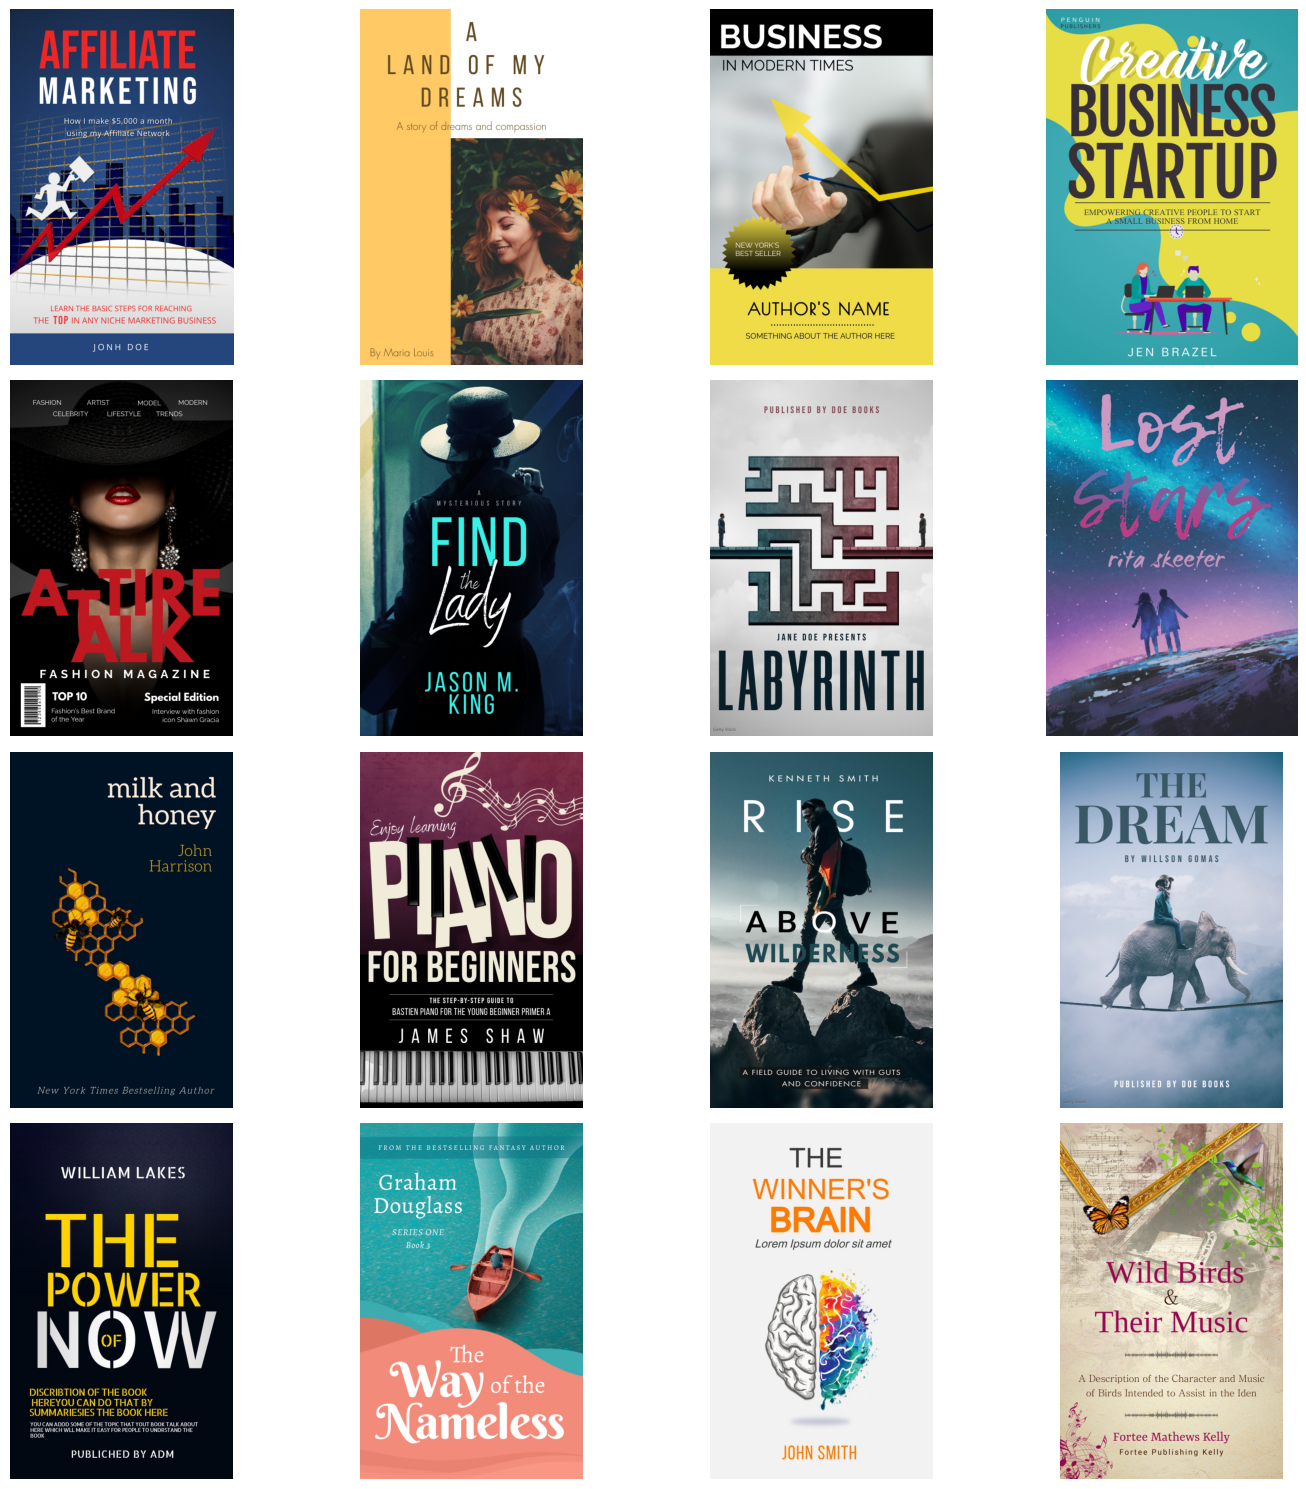

In [4]:
# 이미지 파일들을 순회하면서 출력
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, file_name in enumerate(file_list):
    image_file = os.path.join(image_path, file_name)
    image = Image.open(image_file)
    ax = axs[i // 4, i % 4]
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

### **Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)**

#### **Keras-OCR**

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델 자동 다운로드
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\Minjoo Lee\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Minjoo Lee\.keras-ocr\crnn_kurapan.h5


In [6]:
images = [keras_ocr.tools.read(os.path.join(image_path, image)) for image in file_list]
prediction_groups = [pipeline.recognize([os.path.join(image_path, image)]) for image in file_list]

1/1 [==============================] - 1s 1s/step


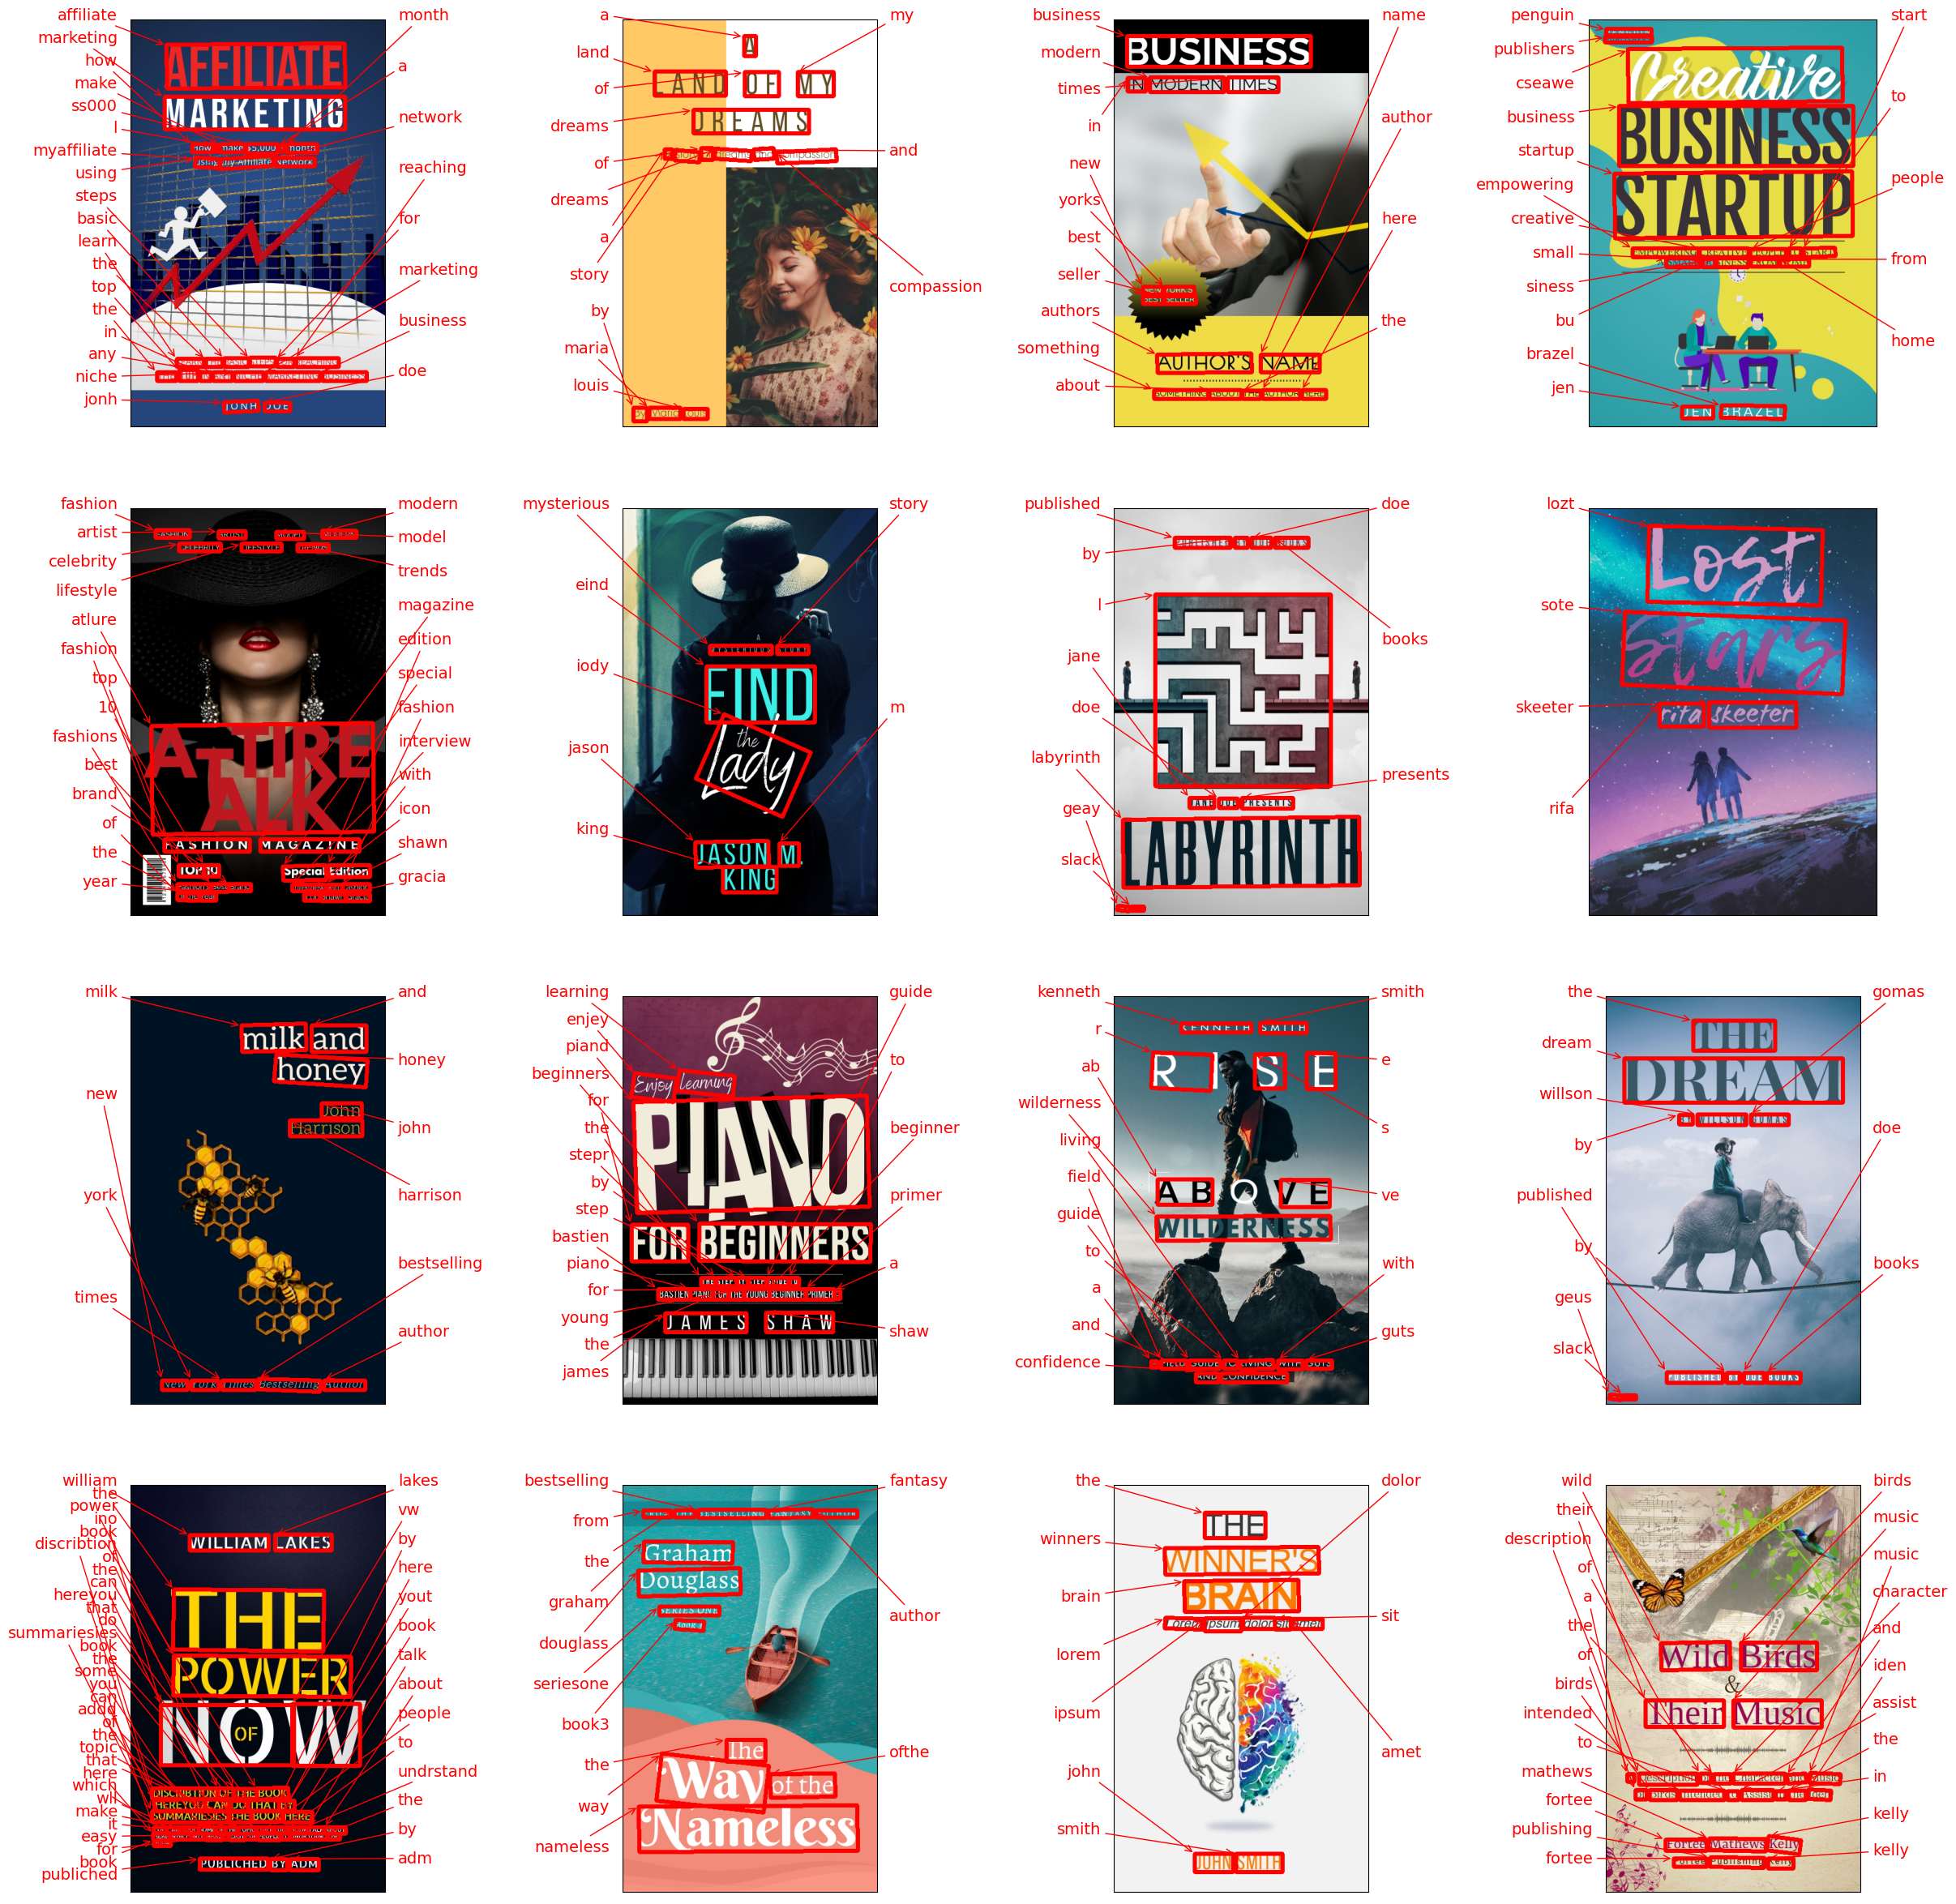

In [7]:
# Plot the predictions
fig, axs = plt.subplots(4, 4, figsize=(30, 30))

for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[4*a+b], 
                                    predictions=prediction_groups[4*a+b][0], ax=axs[a,b])

#### **Tesseract**

In [8]:
def crop_text_regions(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    cropped_images = []
    
    for i, level in enumerate(recognized_data['level']):
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            cropped_image = image.crop((left, top, left + width, top + height))
            cropped_images.append(cropped_image)
    
    return cropped_images

In [9]:
def recognize_text(image):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    recognized_data = pytesseract.image_to_string(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    return recognized_data['text']

In [10]:
def process_image(image_file):
    image_path = os.path.join(image_dir, image_file)
    cropped_images = crop_text_regions(image_path)
    recognized_texts = []
    
    for cropped_image in cropped_images:
        recognized_text = recognize_text(cropped_image)
        recognized_texts.append(recognized_text)
    
    return recognized_texts

원본 이미지에서 줄바꿈이 있는 부분을 텍스트로 인식하고, 그로 인해 인식된 모든 단어 뒤에 '\n'이 추가되는 문제를 해결하기 위해 전체 텍스트에서 '\n'을 제거해주기로 했다.

In [11]:
image_dir = 'C:/Users/Minjoo Lee/aiffel/ocr_python/book_cover'
file_list = [file for file in os.listdir(image_dir) if file.endswith('.jpg')]

# 이미지 파일들을 병렬로 처리
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(process_image, file_list)
    
for image_file, result in zip(file_list, results):
    recognized_texts = [text.replace('\n', '') for text in result]
    print(f"Image File: {image_file}")
    print(f"Recognized Texts: {recognized_texts}")
    print("-" * 50)

Image File: affiliate_marketing.jpg
Recognized Texts: ['MARKETING', 'wiehui', '|', 'sarcl 4=', '$5,000', 'cl', 'month', '—', 'using', 'my-Affitidte', 'Network', 'A', '| FARN', 'TRE', 'BASIC', 'SIECRS', '(ie', 'REAC HIN (,', 'THE', 'TUP', 'Ny', 'ANY', 'NICHE', 'MARKETING,', 'RBLUISINESS', '——', 'THE TOP IN ANY NICHE MARKETING BUSINESS,', 'JONA', 'Or']
--------------------------------------------------
Image File: a_land_of_my_dreams.jpg
Recognized Texts: ['']
--------------------------------------------------
Image File: business_in_modern_times.jpg
Recognized Texts: ['BUSINESS', 'IN', 'MODERN', 'TIMES', 'BUSINESS', '_ ~ =', 'SOME THING', 'ABOU |', 'TRE', 'ALI THOR', 'wied dae']
--------------------------------------------------
Image File: creative_business_startup.jpg
Recognized Texts: ['Pie LISAHERHS', 'f', '7}', 'ITICINIES', '\\', 'e', '(', 'PEC)PL F', '1Q)', 'SiLART', '', 'sien', 'RRO', 'H(oVE', 'a', 'ae', 'ees erYggg& EES oa. ee', '']
----------------------------------------------

### **Step3. 테스트 결과 정리**

특정 이미지 5개를 선택하여 각 이미지에 대한 결과를 더 자세히 확인해보기로 했다.

먼저 Keras-OCR부터 확인해보자.

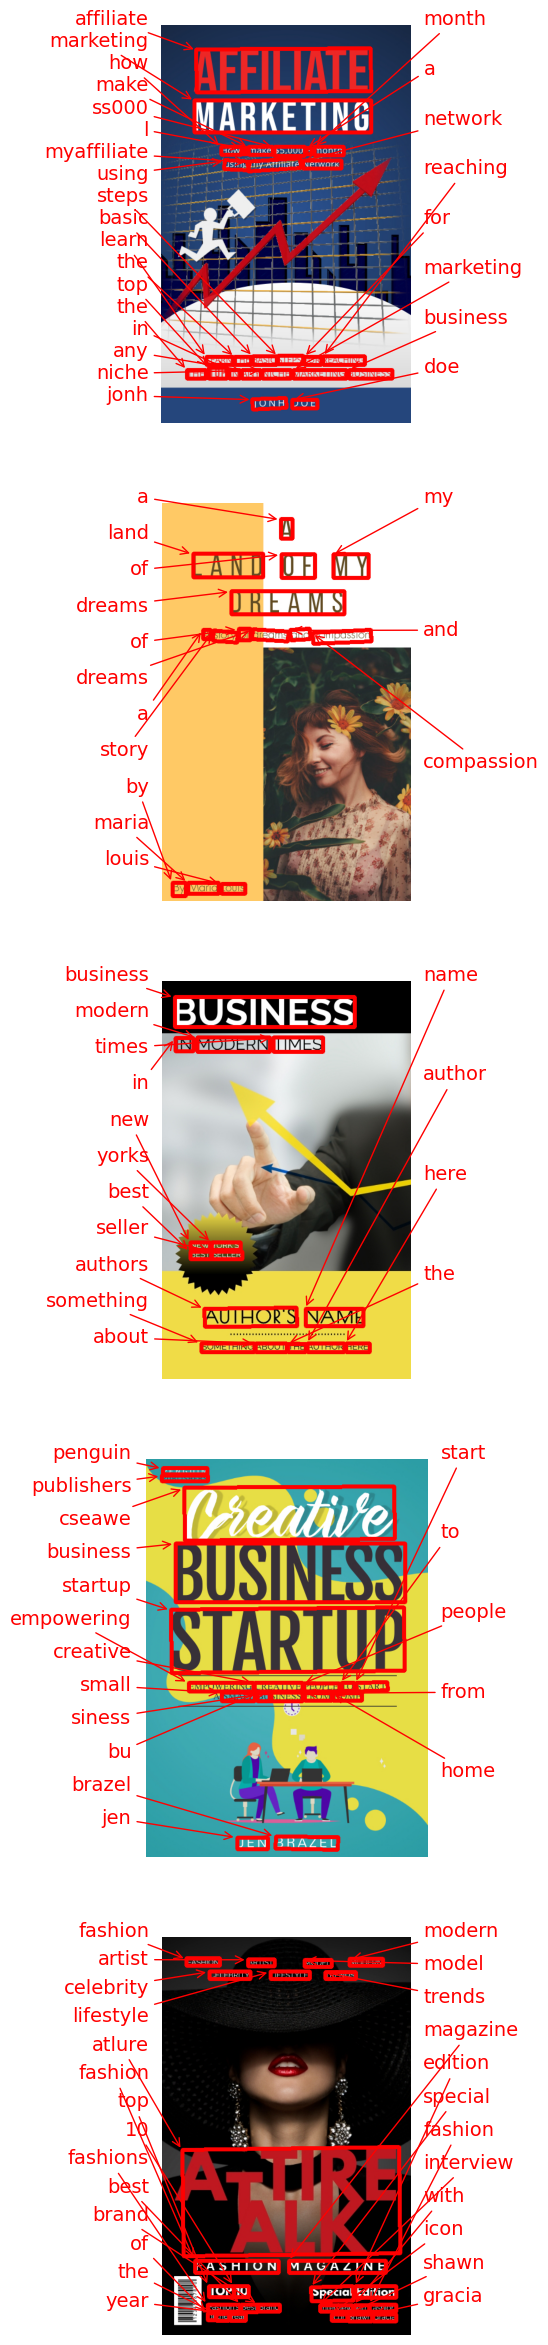

In [12]:
# 다섯 개의 이미지 인덱스
target_indices = [0, 1, 2, 3, 4]

# 이미지와 예측 결과를 함께 표시
fig, axs = plt.subplots(5, 1, figsize=(6, 30))

for i, target_index in enumerate(target_indices):
    prediction = prediction_groups[target_index][0]
    keras_ocr.tools.drawAnnotations(image=images[target_index], predictions=prediction, ax=axs[i])
    axs[i].axis('off')

plt.show()

Keras-OCR은 대부분의 단어를 정확하게 판별해내지만, 글씨체가 약간 변형되거나 필기체와 같은 경우에는 인식이 어려운 것으로 확인할 수 있다. 또한 작은 글씨도 비교적 잘 인식하는 경향이 있지만, 한 단어 내에서 한 글자의 위치가 다른 글자들과 평행하지 않고 약간 아래에 작성된 경우에도 인식을 제대로 수행하지 못하는 것으로 보인다.  

그렇다면 Tesseract는 어떨까?

In [13]:
# 이미지 파일들을 병렬로 처리
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(process_image, file_list)
    
# 상위 5개 이미지 결과 출력
for image_file, result in zip(file_list[:5], results):
    recognized_texts = [text.replace('\n', '') for text in result]
    print(f"Image File: {image_file}")
    print(f"Recognized Texts: {recognized_texts}")
    print("-" * 50)

Image File: affiliate_marketing.jpg
Recognized Texts: ['MARKETING', 'wiehui', '|', 'sarcl 4=', '$5,000', 'cl', 'month', '—', 'using', 'my-Affitidte', 'Network', 'A', '| FARN', 'TRE', 'BASIC', 'SIECRS', '(ie', 'REAC HIN (,', 'THE', 'TUP', 'Ny', 'ANY', 'NICHE', 'MARKETING,', 'RBLUISINESS', '——', 'THE TOP IN ANY NICHE MARKETING BUSINESS,', 'JONA', 'Or']
--------------------------------------------------
Image File: a_land_of_my_dreams.jpg
Recognized Texts: ['']
--------------------------------------------------
Image File: business_in_modern_times.jpg
Recognized Texts: ['BUSINESS', 'IN', 'MODERN', 'TIMES', 'BUSINESS', '_ ~ =', 'SOME THING', 'ABOU |', 'TRE', 'ALI THOR', 'wied dae']
--------------------------------------------------
Image File: creative_business_startup.jpg
Recognized Texts: ['Pie LISAHERHS', 'f', '7}', 'ITICINIES', '\\', 'e', '(', 'PEC)PL F', '1Q)', 'SiLART', '', 'sien', 'RRO', 'H(oVE', 'a', 'ae', 'ees erYggg& EES oa. ee', '']
----------------------------------------------

같은 이미지 5개를 사용하여 결과를 확인한 결과, Keras OCR와 Tesseract의 결과가 상당히 다르게 나타났다. Tesseract의 경우에는 일부 이미지에서 텍스트가 존재하더라도 전혀 인식하지 못하는 경우가 발생했으며, 전체적으로 단어들을 제대로 인식하지 못한 모습을 보였다. 실제로 제대로 인식된 단어의 수는 매우 제한적인 것으로 확인되었다.

### **Step4. 결과 분석과 결론 제시**

#### **평가 기준**
* 정확성: 추출된 도서 정보가 실제 도서의 정보와 정확하게 일치하는가?
* 일관성: 추출된 정보가 여러 이미지에서 동일한 도서에 대해 일관성을 가지고 추출되는가?
* 다양한 도서 표지 처리: 다양한 종류의 도서 표지 이미지에 대해 OCR 모델이 정확하게 작동하는가?

#### **결론**   
Keras-OCR은 대부분의 단어를 정확하게 판별하는 능력을 보여주었으며, 일관성 측면에서도 우수한 성능을 보였다. 그러나 글씨체 변형이나 필기체와 같은 경우에는 인식이 어려웠으며, 한 단어 내에서 글자 위치가 다르게 배치되는 경우에도 인식이 제대로 이루어지지 않았다. 반면에 Tesseract는 전체적으로 단어들을 제대로 인식하지 못하는 모습을 보였다. 따라서 정확성과 일관성 측면에서 Keras-OCR이 Tesseract보다 우수한 성능을 보여주었다. 두 모델의 다양한 도서 표지 이미지 처리에 대해서도 Keras-OCR이 대부분의 경우에서 좋은 성능을 보였으나, 특정한 경우에는 인식 오류가 발생할 수 있었다. 종합적으로 평가하면, Keras-OCR이 Tesseract보다 뛰어난 OCR 모델로 평가된다.

---

### **프로젝트 회고**
이번 프로젝트는 생각보다 간단해서 어렵지 않았던 것 같다. 그러나 노드에서 제공된 함수들이 단일 이미지에만 작동하도록 설계되어 있어 여러 이미지에 대해 적용하기 위해 수정이 필요했는데, 이 부분이 어려움을 주었다. 이 과정에서 이미지를 병렬로 처리하여 처리 속도를 향상시킬 수 있는 방법을 알게 되었으며, 또한 Tesseract를 적용했을 때 결과를 한눈에 보기 좋게 출력하는 방법에 대한 고민을 많이 했다. 변수명을 잘못 입력하거나 기존 변수명을 불러올 때 오류가 발생하는 경우도 있었는데, 변수명을 변경하여 다시 정의하니 문제가 해결되었다. 아무래도 이전에 정의한 변수가 덮어씌워지는 현상이 발생해서 그런 것 같다. 필요한 함수들은 이미 구현되어 있어 큰 어려움 없이 프로젝트를 마무리할 수 있었고, 프로젝트를 진행하면서 구동 방식에 대해 더 명확하게 이해하고 넘어갈 수 있었다. 이번에는 조금 귀찮아서 사용해보지 못한 Google API도 나중에 활용해보면 좋을 것 같다.  

변수의 역할과 의미에 맞는 이름을 선택하고, 일관성 있게 작성하는 습관을 가지자!

#### **새로 알게 된 것!**
**기계는 어떤 과정으로 문자를 읽을까?**
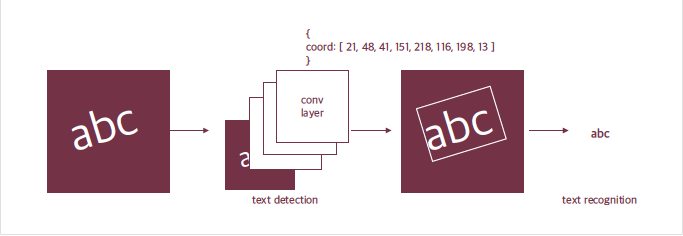  
1. Text Detection(문자 검출): 입력 받은 사진 속에서 문자의 위치를 찾아낸다.
2. Text Recognition(문자 인식): 찾은 문자 영역으로부터 문자를 읽어낸다.

**문자의 영역을 표현하는 방법에는 어떤 것이 있을까?**
1. 축에 정렬된 사각형 Bounding box
2. 돌아간 사각형 Oriented bounding box
3. 자유로운 사각형 Quadrangle
4. 다각형 Polygon
5. Pixel 수준으로 영역을 표현한 Mask

**LeNet**  
LeNet은 CNN의 "hello, world!"로 우편번호나 손글씨를 읽기 위해서 만들어졌다.
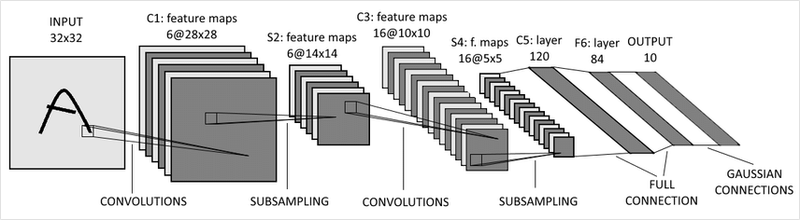

**강건한(robust) 모델은 어떻게 만들 수 있을까?**
* 가려진 케이스에 대한 데이터를 확보
* Augmentation을 통해서 해당 케이스에 대한 강건성을 확보

**딥러닝 기반 객체 검출 방법**
* Regression(회귀): 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습
* Segmentation(세그멘테이션): 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제

**문자 인식이란?**  
사진 속에서 문자를 검출해 내는 검출 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정  
  
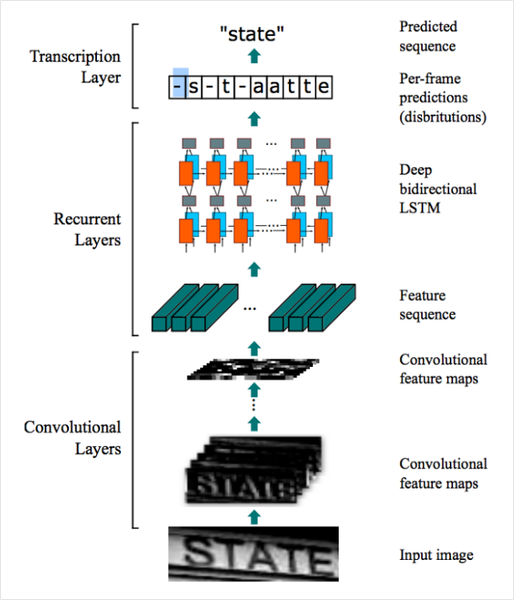

CNN + RNN = CRNN  
이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것

**참고한 레퍼런스**
<br>4차 산업 고도화의 '촉매'가 되는 OCR https://blog.naver.com/kpostbank/221343765011
<br>구글 OCR API https://cloud.google.com/vision?hl=ko
<br>Scene Text Detection with Polygon Offsetting and Border Augmentation https://www.mdpi.com/2079-9292/9/1/117
<br>LeNet https://www.youtube.com/watch?v=m3BrTjo2zUA
<br>딥러닝을 활용한 객체 탐지 알고리즘 이해하기 https://blogs.sas.com/content/saskorea/2018/12/21/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EA%B0%9D%EC%B2%B4-%ED%83%90%EC%A7%80-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0/
<br>네이버 데뷰 2018, 이활석님의 CRAFT 모델소개와 연구 경험 https://tv.naver.com/v/4578167
<br>사진 속 글자 읽기, OCR (Optical character recognition) https://www.youtube.com/watch?v=ckRFBl_XWFg
<br>keras_ocr 공식문서 https://keras-ocr.readthedocs.io/en/latest/index.html
<br>unsplash https://unsplash.com/ko/s/%EC%82%AC%EC%A7%84/text
<br>keras-ocr 파이프라인 https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py
<br>병렬로 작업을 처리하려면? ― concurrent.futures https://wikidocs.net/124348